Zhenyu's DNN for drug prediction 

In [48]:

import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import r2_score
from torch import layer_norm, nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,average_precision_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [49]:
drug=pd.read_csv('GDSC2_expression14.csv')

drug.shape
drug
# Result: 805 tumor cells (cell lines) and 17419 genes

,Unnamed: 0,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
0,DATA.683665,3.238273,2.982254,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,...,3.103752,3.724013,3.981948,2.823245,5.866047,3.095716,3.274367,3.056214,9.446305,3.530871
1,DATA.683667,7.780713,2.753253,9.960137,4.351073,3.716740,3.222277,8.221606,3.823474,4.756228,...,3.175476,3.779354,4.504481,2.690651,3.347520,3.230713,3.102091,3.169188,9.810430,3.266915
2,DATA.684052,7.301344,2.890533,9.922489,4.125088,3.678987,3.096576,3.588391,4.809305,4.951782,...,3.299300,3.762301,4.177345,2.499803,5.054260,3.003521,3.068187,3.135479,9.073222,3.098364
3,DATA.684057,8.233101,2.824687,10.015884,4.749715,3.839433,3.142754,5.329830,3.272124,5.538055,...,3.081750,3.226083,4.666295,2.491254,6.261573,3.031862,3.322455,2.813440,8.893197,3.266184
4,DATA.684059,8.333466,3.966757,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,...,3.055770,3.738082,4.705392,2.667882,3.885425,2.993918,3.219777,3.033869,8.691401,3.279230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,DATA.1659928,7.245503,2.898369,9.737324,4.295495,3.429522,3.264985,3.509126,6.422919,5.522948,...,3.302293,3.237528,3.770028,2.650564,5.786714,3.189778,3.528351,3.580661,9.717357,3.704140
801,DATA.1660034,8.579664,2.778771,9.768011,5.713156,4.455503,3.388605,3.760805,7.483606,6.906877,...,3.972611,4.007318,3.605398,2.565349,3.260777,2.983984,3.717966,3.719941,9.798886,3.396734
802,DATA.1660035,8.077116,2.781325,10.038055,5.205411,3.758069,3.111444,3.714148,8.947314,6.013510,...,4.991264,3.312884,4.008429,2.772584,5.787669,3.283547,3.740781,3.471996,8.837456,3.143362
803,DATA.1660036,7.797699,2.640900,9.463400,4.039697,3.854522,3.212820,3.369225,8.969264,6.660734,...,6.654799,3.734381,4.158913,2.849266,4.772469,3.101758,3.662190,3.329809,9.491964,3.317055


In [50]:

label=pd.read_csv('GDSC2_label_14drugs.csv') 

label.shape
label.head(5)

# Result: 805 tumor cells (cell lines) and 14 drugs

,Unnamed: 0,Cisplatin,Crizotinib,Dabrafenib,Docetaxel,Entinostat,Erlotinib,Gefitinib,I-BET-762,Ibrutinib,JQ1,Osimertinib,PLX-4720,Tamoxifen,Trametinib
0,DATA.683665,0.964141,0.995440,0.991812,0.481972,0.737832,0.989480,0.984074,0.815841,0.986655,1.0,0.990236,0.971408,0.964728,0.994088
1,DATA.683667,0.959592,0.952548,0.987206,0.518361,0.751731,0.958145,0.958999,0.966871,0.988762,1.0,0.954614,0.984709,0.912034,0.989145
2,DATA.684052,0.724311,0.988106,0.956075,0.397937,0.883226,0.973575,0.989079,0.937767,0.981702,1.0,0.961193,0.958166,0.949760,0.965742
3,DATA.684057,1.000000,0.971430,1.000000,0.186942,0.790366,1.000000,1.000000,0.985318,0.958920,1.0,1.000000,0.949483,1.000000,1.000000
4,DATA.684059,0.767399,0.991917,0.976539,0.371230,0.852240,0.982904,0.972875,0.987804,0.944549,1.0,0.973288,0.955077,0.930646,0.989165


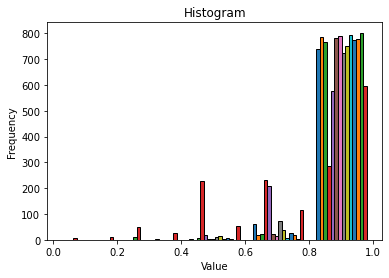

In [56]:
## explore the label data since very biased 
import matplotlib.pyplot as plt

#label.set_index('Unnamed: 0', inplace=True)

# Create histogram
plt.hist(label, bins=5, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show plot
plt.show()

## skewed to 1 (resistant)

(array([  4.,   7.,   6.,  25., 763.]),
 array([0.044143 , 0.2353144, 0.4264858, 0.6176572, 0.8088286, 1.       ]),
 <BarContainer object of 5 artists>)

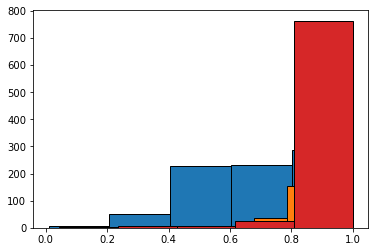

In [54]:
plt.hist(label["Docetaxel"], bins=5, edgecolor='black')
plt.hist(label["Cisplatin"], bins=5, edgecolor='black')
plt.hist(label["Crizotinib"], bins=5, edgecolor='black')
plt.hist(label["Dabrafenib"], bins=5, edgecolor='black')

## it seems the Docetaxel has realatvie better distribution ... 


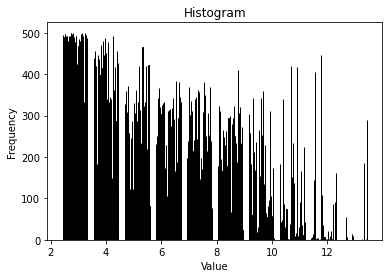

In [58]:
# Create histogram
drug
drug.set_index('Unnamed: 0', inplace=True)

plt.hist(drug.iloc[0:500,0:500], bins=10, edgecolor='black')
#plt.hist(df_tumor, bins=10, edgecolor='black')


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show plot
plt.show()



In [43]:
## biased sample processing

# e.g feature selection

# up/downsampling, will do later


In [44]:

import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import r2_score
from torch import layer_norm, nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,average_precision_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [59]:
# use "Docetaxel" as example

X_train, X_test, y_train, y_test = train_test_split(drug, label,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2)


print("The shape of X_train is",X_train.shape)
print("The shape of X_test is",X_test.shape)
print("The length of y_train is",len(y_train))
print("The length of y_test is",len(y_test))



X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                 shuffle = True,
                                                                 random_state = 321,
                                                                 test_size=.15)
print("Shape of X_train_train", X_train_train.shape)
print("Shape of X_val", X_val.shape)
print("Length of y_train_train", len(y_train_train))
print("Length of y_val", len(y_val))

## there should be 5 fold cross validation but ..... 

The shape of X_train is (644, 17419)
The shape of X_test is (161, 17419)
The length of y_train is 644
The length of y_test is 161
Shape of X_train_train (547, 17419)
Shape of X_val (97, 17419)
Length of y_train_train 547
Length of y_val 97


In [60]:
X_train_train.iloc[:,0:17419]
y_train_train["Docetaxel"]

Unnamed: 0
DATA.1240212    0.634964
DATA.949177     0.354805
DATA.906828     0.485716
DATA.687514     0.863892
DATA.909698     0.497547
                  ...   
DATA.753532     0.400672
DATA.906763     0.456183
DATA.998184     0.468174
DATA.907273     0.489474
DATA.724825     0.495736
Name: Docetaxel, Length: 547, dtype: float64

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,random_state = 84)
    # Train the model on training data
rf.fit(X_train_train.iloc[:,0:17419], y_train_train["Docetaxel"])



predicted_classes = rf.predict(X_test)
predicted_value = predicted_classes
        
        

In [63]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(y_test["Docetaxel"])
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]


b

,Docetaxel
Unnamed: 0,
DATA.906797,0.615560
DATA.910691,0.840820
DATA.1290809,0.863816
DATA.910951,0.465619
DATA.909778,0.894493
...,...
DATA.906801,0.915833
DATA.905955,0.969296
DATA.908130,0.948140


Docetaxel’s final rmse value is = 0.000000
Docetaxel R-squared value is = 0.210311


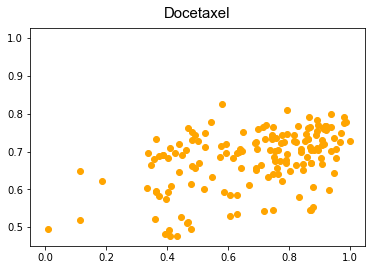

In [64]:

 
    # RMSE
rse = ((b["Docetaxel"]-a[0])**2).sum()
mse = rse / len(b)
rmse = np.sqrt(mse)
print("%s’s final rmse value is = %f" % ("Docetaxel",rmse))
    
    # R-squared value
r2_value = r2_score(b,a)
print("%s R-squared value is = %f" % ("Docetaxel",r2_value))
rmselist=[]
r2list=[]
rmselist.append(rmse)
r2list.append(r2_value)
          
plt.plot(1,1,1)
plt.scatter(y_test["Docetaxel"],predicted_value,c='orange')
plt.title("Docetaxel",fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
plt.tick_params(labelsize=10)

In [65]:
## LASSO regreesion 

from sklearn.linear_model import Lasso

lasso_regressor = Lasso(alpha=0.001)
lasso_regressor.fit(X_train_train.iloc[:,0:17419], y_train_train["Docetaxel"])

predicted_classes = lasso_regressor.predict(X_test)
predicted_value = predicted_classes

/Users/zhenyu/opt/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07052075059665502, tolerance: 0.0019004653575369684
  positive)


In [66]:


a = pd.DataFrame(predicted_value)
b = pd.DataFrame(y_test["Docetaxel"])
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]
c

,Predicted,Test
0,0.707161,NaN
1,0.698961,NaN
2,0.660822,NaN
3,0.519853,NaN
4,0.779427,NaN
...,...,...
DATA.949093,NaN,0.936913
DATA.949156,NaN,0.880296
DATA.949157,NaN,0.822192
DATA.949161,NaN,0.522165


Docetaxel’s final rmse value is = 0.000000
Docetaxel R-squared value is = -0.003043


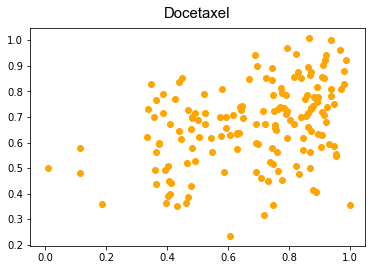

In [129]:

rse = ((b["Docetaxel"]-a[0])**2).sum()
mse = rse / len(b)
rmse = np.sqrt(mse)
print("%s’s final rmse value is = %f" % ("Docetaxel",rmse))
    
    # R-squared value
r2_value = r2_score(b,a)
print("%s R-squared value is = %f" % ("Docetaxel",r2_value))
rmselist=[]
r2list=[]
rmselist.append(rmse)
r2list.append(r2_value)
          
plt.plot(1,1,1)
plt.scatter(y_test["Docetaxel"],predicted_value,c='orange')
plt.title("Docetaxel",fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
plt.tick_params(labelsize=10)

In [62]:
# ## pip install xgboost
# # xgboost is not working in the MAC M1 

# import xgboost as xgb

# model = xgb.XGBRegressor()
# model.fit(X_train_train.iloc[:,0:17419], y_train_train["Docetaxel"])


# predicted_classes = model.predict(X_test)
# predicted_value = predicted_classes

In [15]:
## Try SVR 
from sklearn.svm import SVR

svr_lin = SVR(C=0.05,kernel='rbf')
svr_lin.fit(X_train_train.iloc[:,0:17419], y_train_train[dname]).predict(X_test)


predicted_classes = svr_lin.predict(X_test)
predicted_value = predicted_classes


rse = ((b["Docetaxel"]-a[0])**2).sum()
mse = rse / len(b)
rmse = np.sqrt(mse)
print("%s’s final rmse value is = %f" % ("Docetaxel",rmse))
    
    # R-squared value
r2_value = r2_score(b,a)
print("%s R-squared value is = %f" % ("Docetaxel",r2_value))
rmselist=[]
r2list=[]
rmselist.append(rmse)
r2list.append(r2_value)
          
plt.plot(1,1,1)
plt.scatter(y_test["Docetaxel"],predicted_value,c='orange')
plt.title("Docetaxel",fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
plt.tick_params(labelsize=10)

In [ ]:

### try CNN / DNN 

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

In [28]:
### for 14 drugs 
list(label.columns)[1:]


['Cisplatin',
 'Crizotinib',
 'Dabrafenib',
 'Docetaxel',
 'Entinostat',
 'Erlotinib',
 'Gefitinib',
 'I-BET-762',
 'Ibrutinib',
 'JQ1',
 'Osimertinib',
 'PLX-4720',
 'Tamoxifen',
 'Trametinib']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

drug_list = list(label.columns)[1:]
for dname in drug_list:
    print(dname)

    rf = RandomForestRegressor(n_estimators=100,random_state = 84)
    # Train the model on training data
    rf.fit(X_train_train.iloc[:,0:17419], y_train_train[dname])
    predicted_classes = rf.predict(X_test)
    predicted_value = predicted_classes
        
    a = pd.DataFrame(predicted_value)
    b = pd.DataFrame(y_test[dname])
    c = pd.concat([a,b], axis=1)
    c.columns=["Predicted","Test"]

    
    rse = ((b[dname]-a[0])**2).sum()
    mse = rse / len(b)
    rmse = np.sqrt(mse)
    print("%s’s final rmse value is = %f" % (dname,rmse))
    
    # R-squared value
    r2_value = r2_score(b,a)
    print("%s R-squared value is = %f" % (dname,r2_value))
    rmselist=[]
    r2list=[]
    rmselist.append(rmse)
    r2list.append(r2_value)
          
    plt.plot(1,1,1)
    plt.scatter(y_test[dname],predicted_value,c='orange')
    plt.title(dname,fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
    plt.tick_params(labelsize=10)
    


Crizotinib
Crizotinib’s final rmse value is = 0.000000
Crizotinib R-squared value is = 0.071966
Dabrafenib
Dabrafenib’s final rmse value is = 0.000000
Dabrafenib R-squared value is = 0.317925
Docetaxel
Docetaxel’s final rmse value is = 0.000000
Docetaxel R-squared value is = 0.210311
Entinostat
Entinostat’s final rmse value is = 0.000000
Entinostat R-squared value is = 0.197886
Erlotinib
Erlotinib’s final rmse value is = 0.000000
Erlotinib R-squared value is = 0.206957
Gefitinib
Gefitinib’s final rmse value is = 0.000000
Gefitinib R-squared value is = 0.201544
I-BET-762
I-BET-762’s final rmse value is = 0.000000
I-BET-762 R-squared value is = 0.094523
Ibrutinib
Ibrutinib’s final rmse value is = 0.000000
Ibrutinib R-squared value is = 0.029293
JQ1
